In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

In [2]:
SEED=42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) 

# EDA


In [4]:
df = pd.read_csv('./creditcard.csv') #data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Data는 원래의 데이터를 PCA를 사용해 28차원으로 축소한 28개의 특성과 시간, 거래금액, Label이 존재하는 데이터

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Data는 심각한 불균형을 이루고 있는 것을 확인 가능

In [6]:
df.drop(['Time','Amount'],axis=1,inplace=True)
print(df)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.25141

이 주제에서는 원본 데이터에 차원축소가 진행된 28개의 특성인 V1~V28만 사용할 예정

In [7]:
df.shape 

(284807, 29)

In [8]:
df.isnull().sum() #결측치 존재하지 않음

V1       0
V2       0
V3       0
V4       0
V5       0
V6       0
V7       0
V8       0
V9       0
V10      0
V11      0
V12      0
V13      0
V14      0
V15      0
V16      0
V17      0
V18      0
V19      0
V20      0
V21      0
V22      0
V23      0
V24      0
V25      0
V26      0
V27      0
V28      0
Class    0
dtype: int64

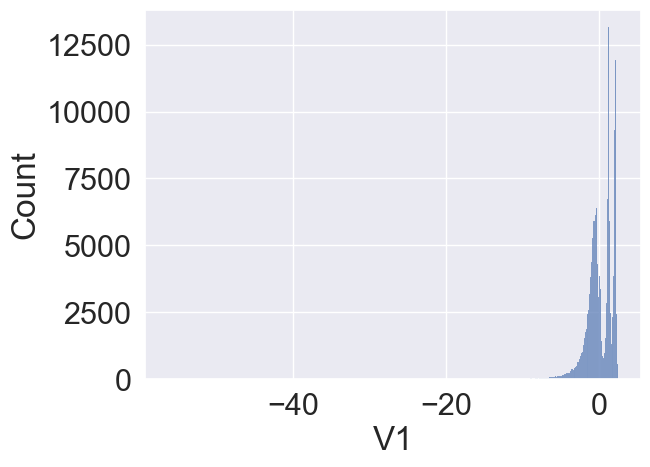

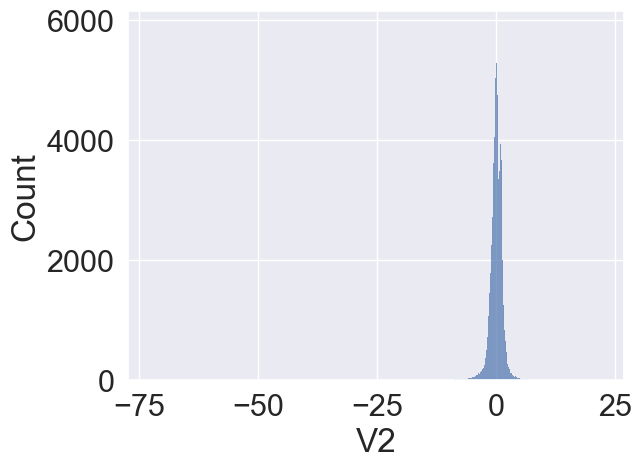

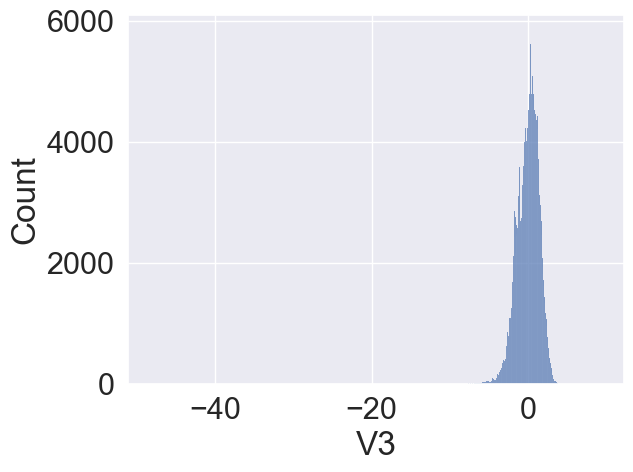

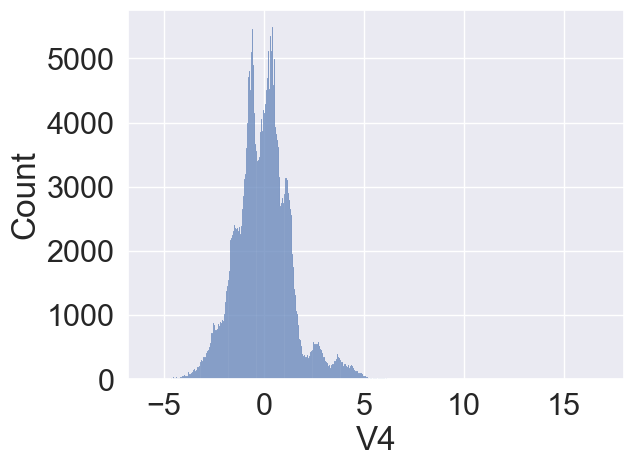

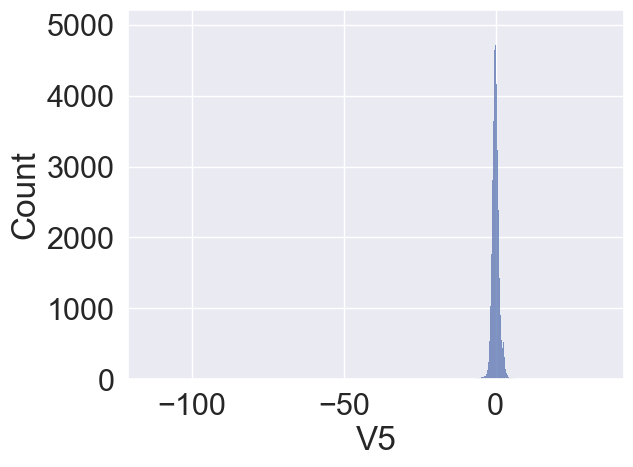

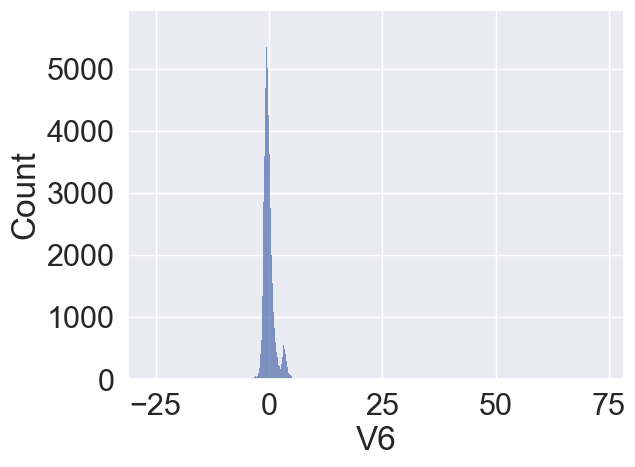

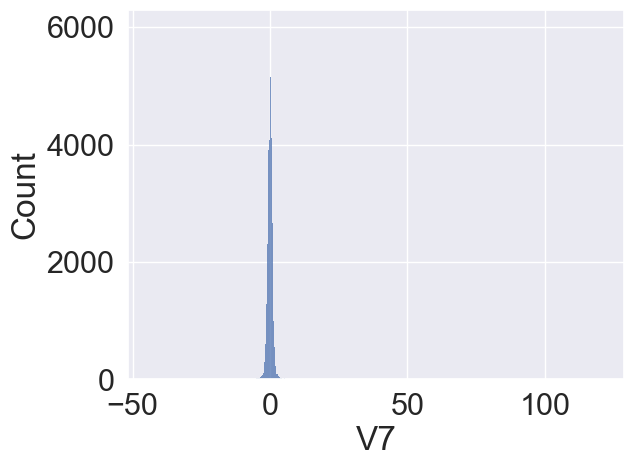

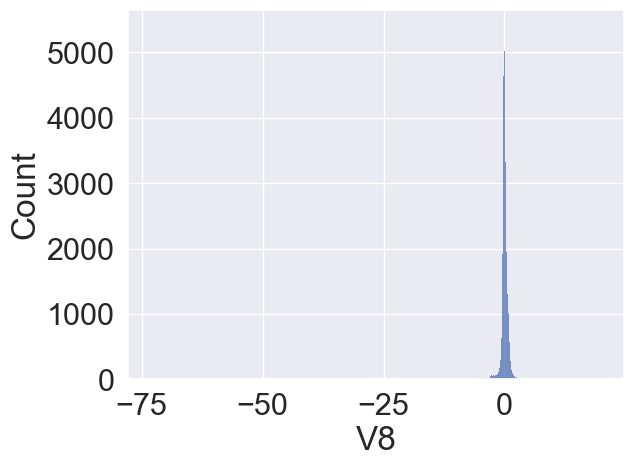

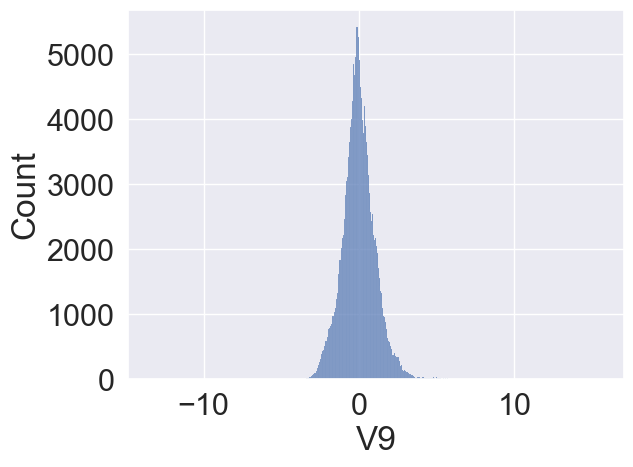

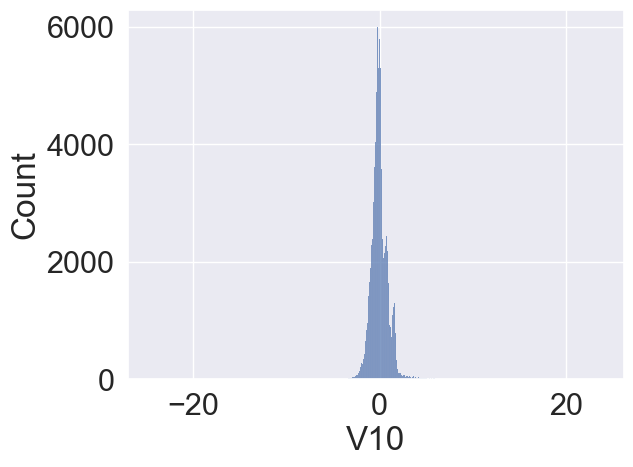

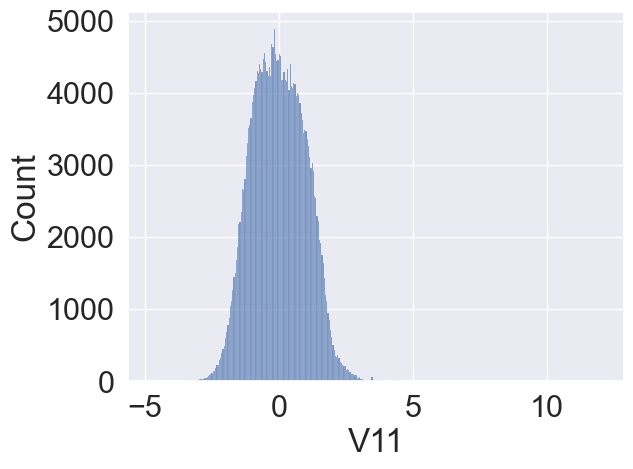

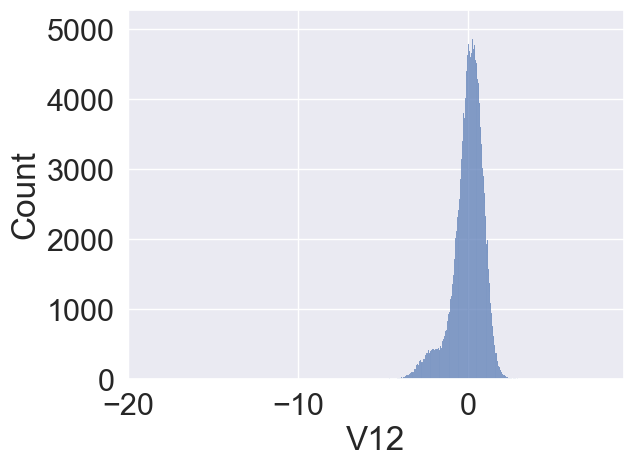

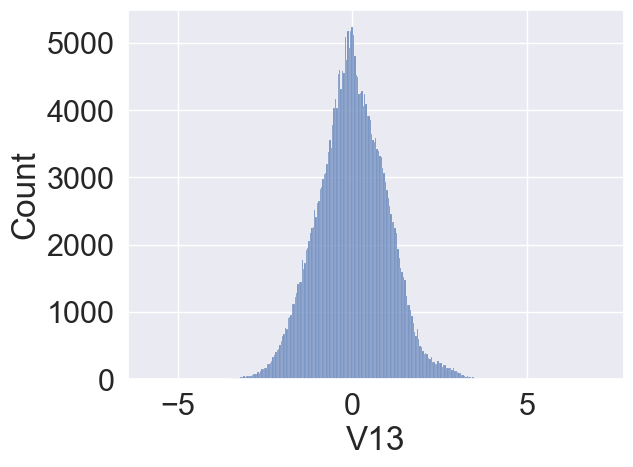

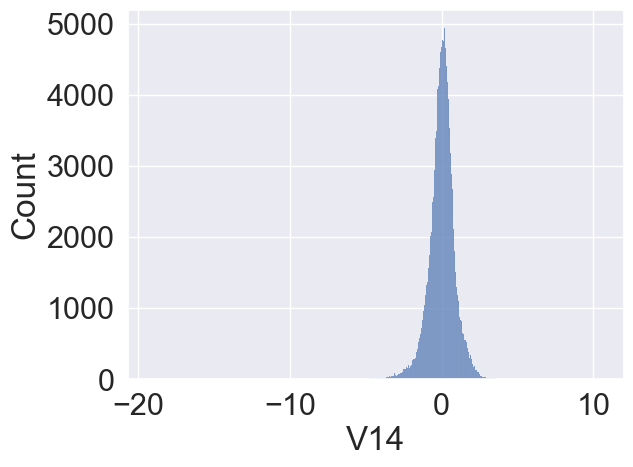

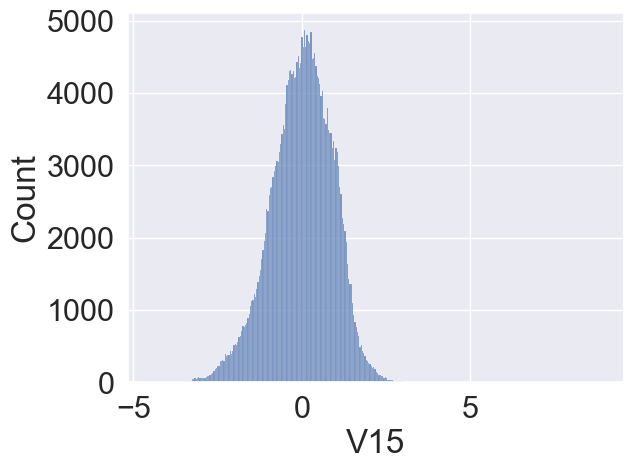

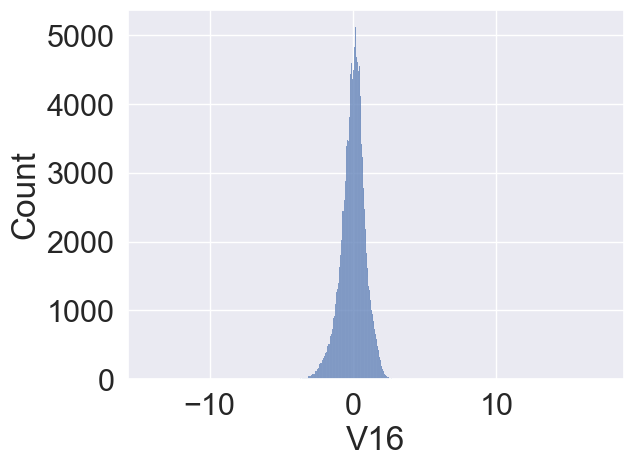

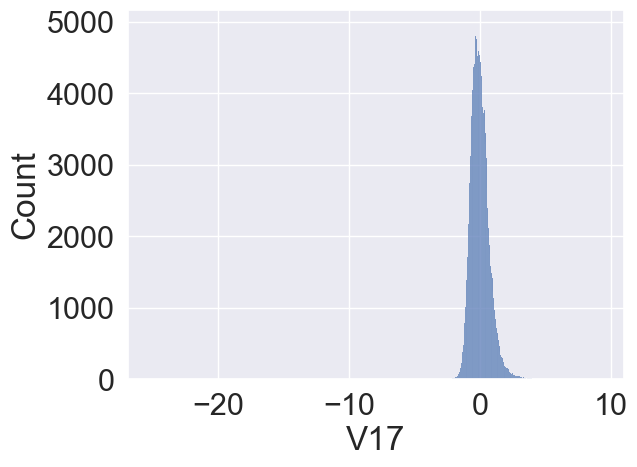

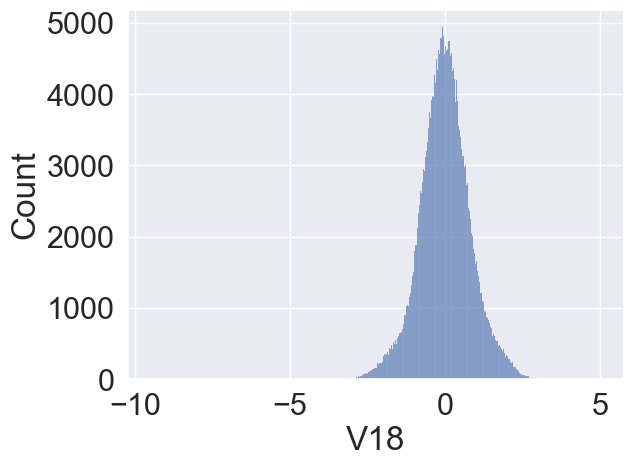

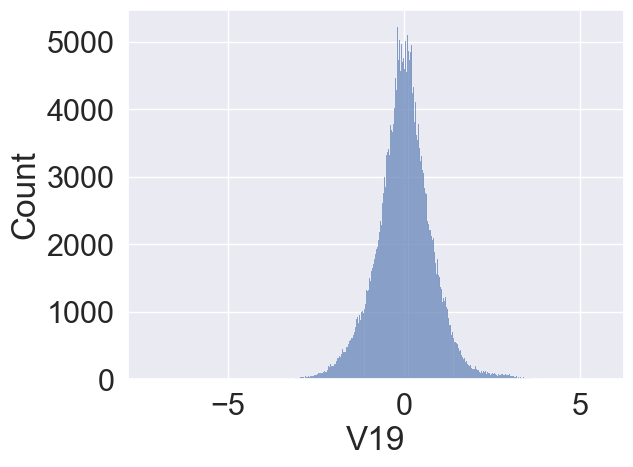

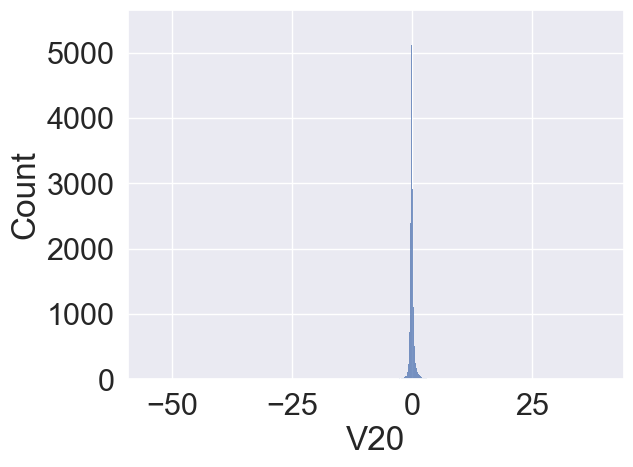

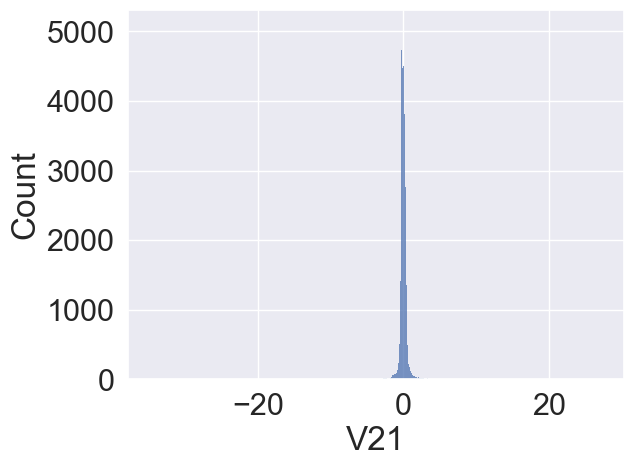

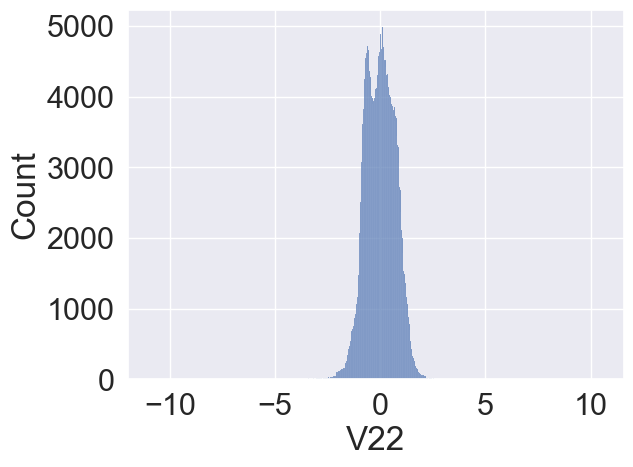

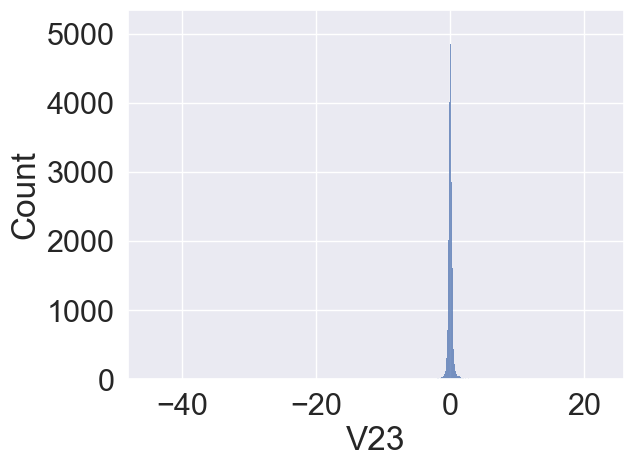

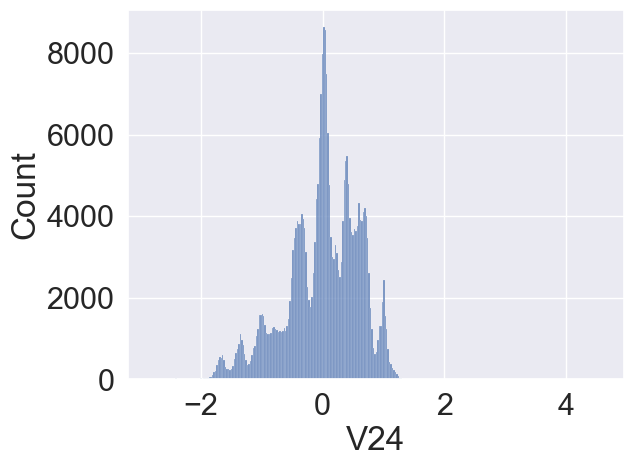

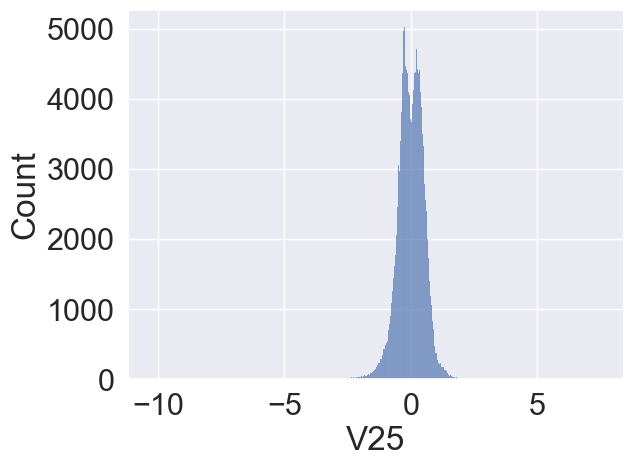

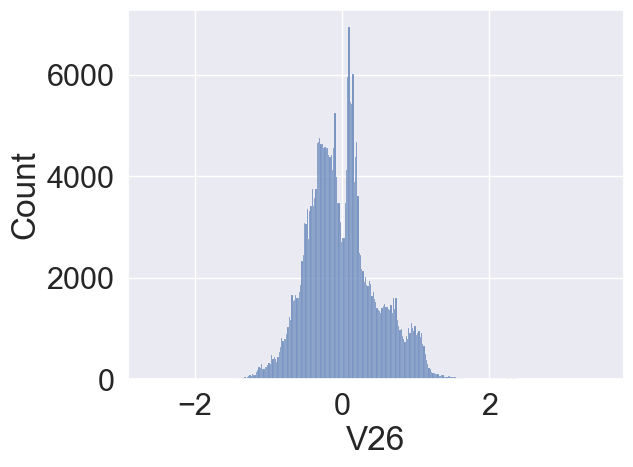

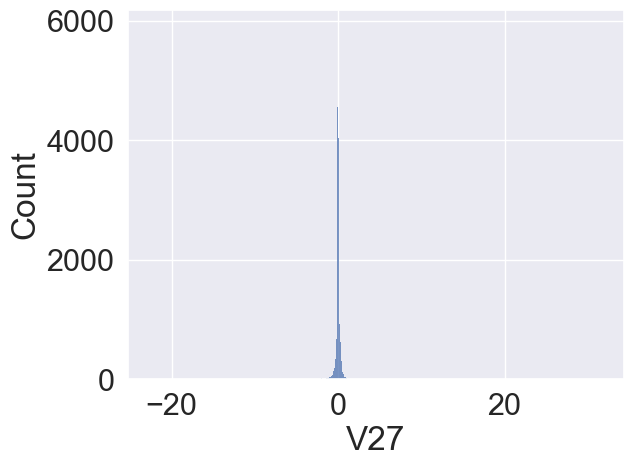

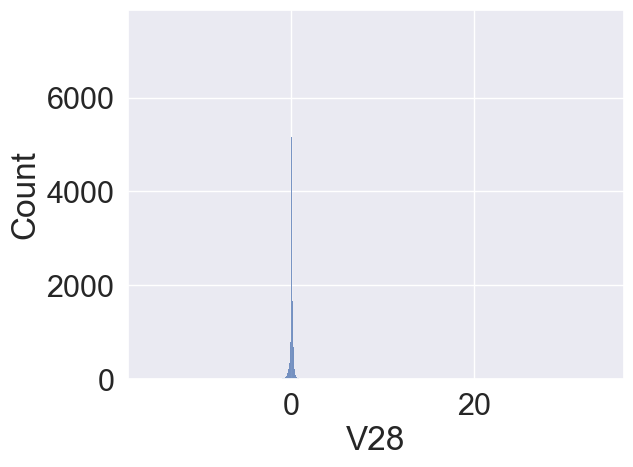

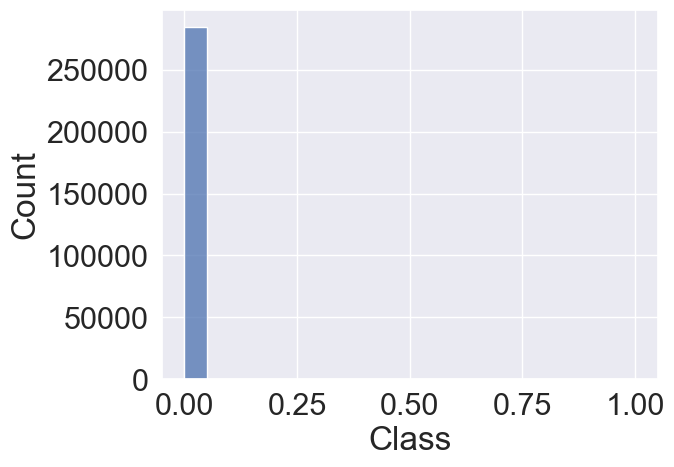

In [173]:
col = df.columns # 특성별 데이터 값의 분포. 대부분 정규분포를 띔
for e in col:
    sns.histplot(x=df[e])
    plt.show()

In [9]:
correlation_df =df.corr(method='pearson') #상관계수 Dataframe 생성

In [10]:
correlation_df.loc[abs(correlation_df['Class']) > 0.1 , ['Class']] 
#'Class' Column과 상관계수가 0.1 이상인 특성찾기

,Class
V1,-0.101347
V3,-0.192961
V4,0.133447
V7,-0.187257
V10,-0.216883
V11,0.154876
V12,-0.260593
V14,-0.302544
V16,-0.196539
V17,-0.326481


<AxesSubplot: >

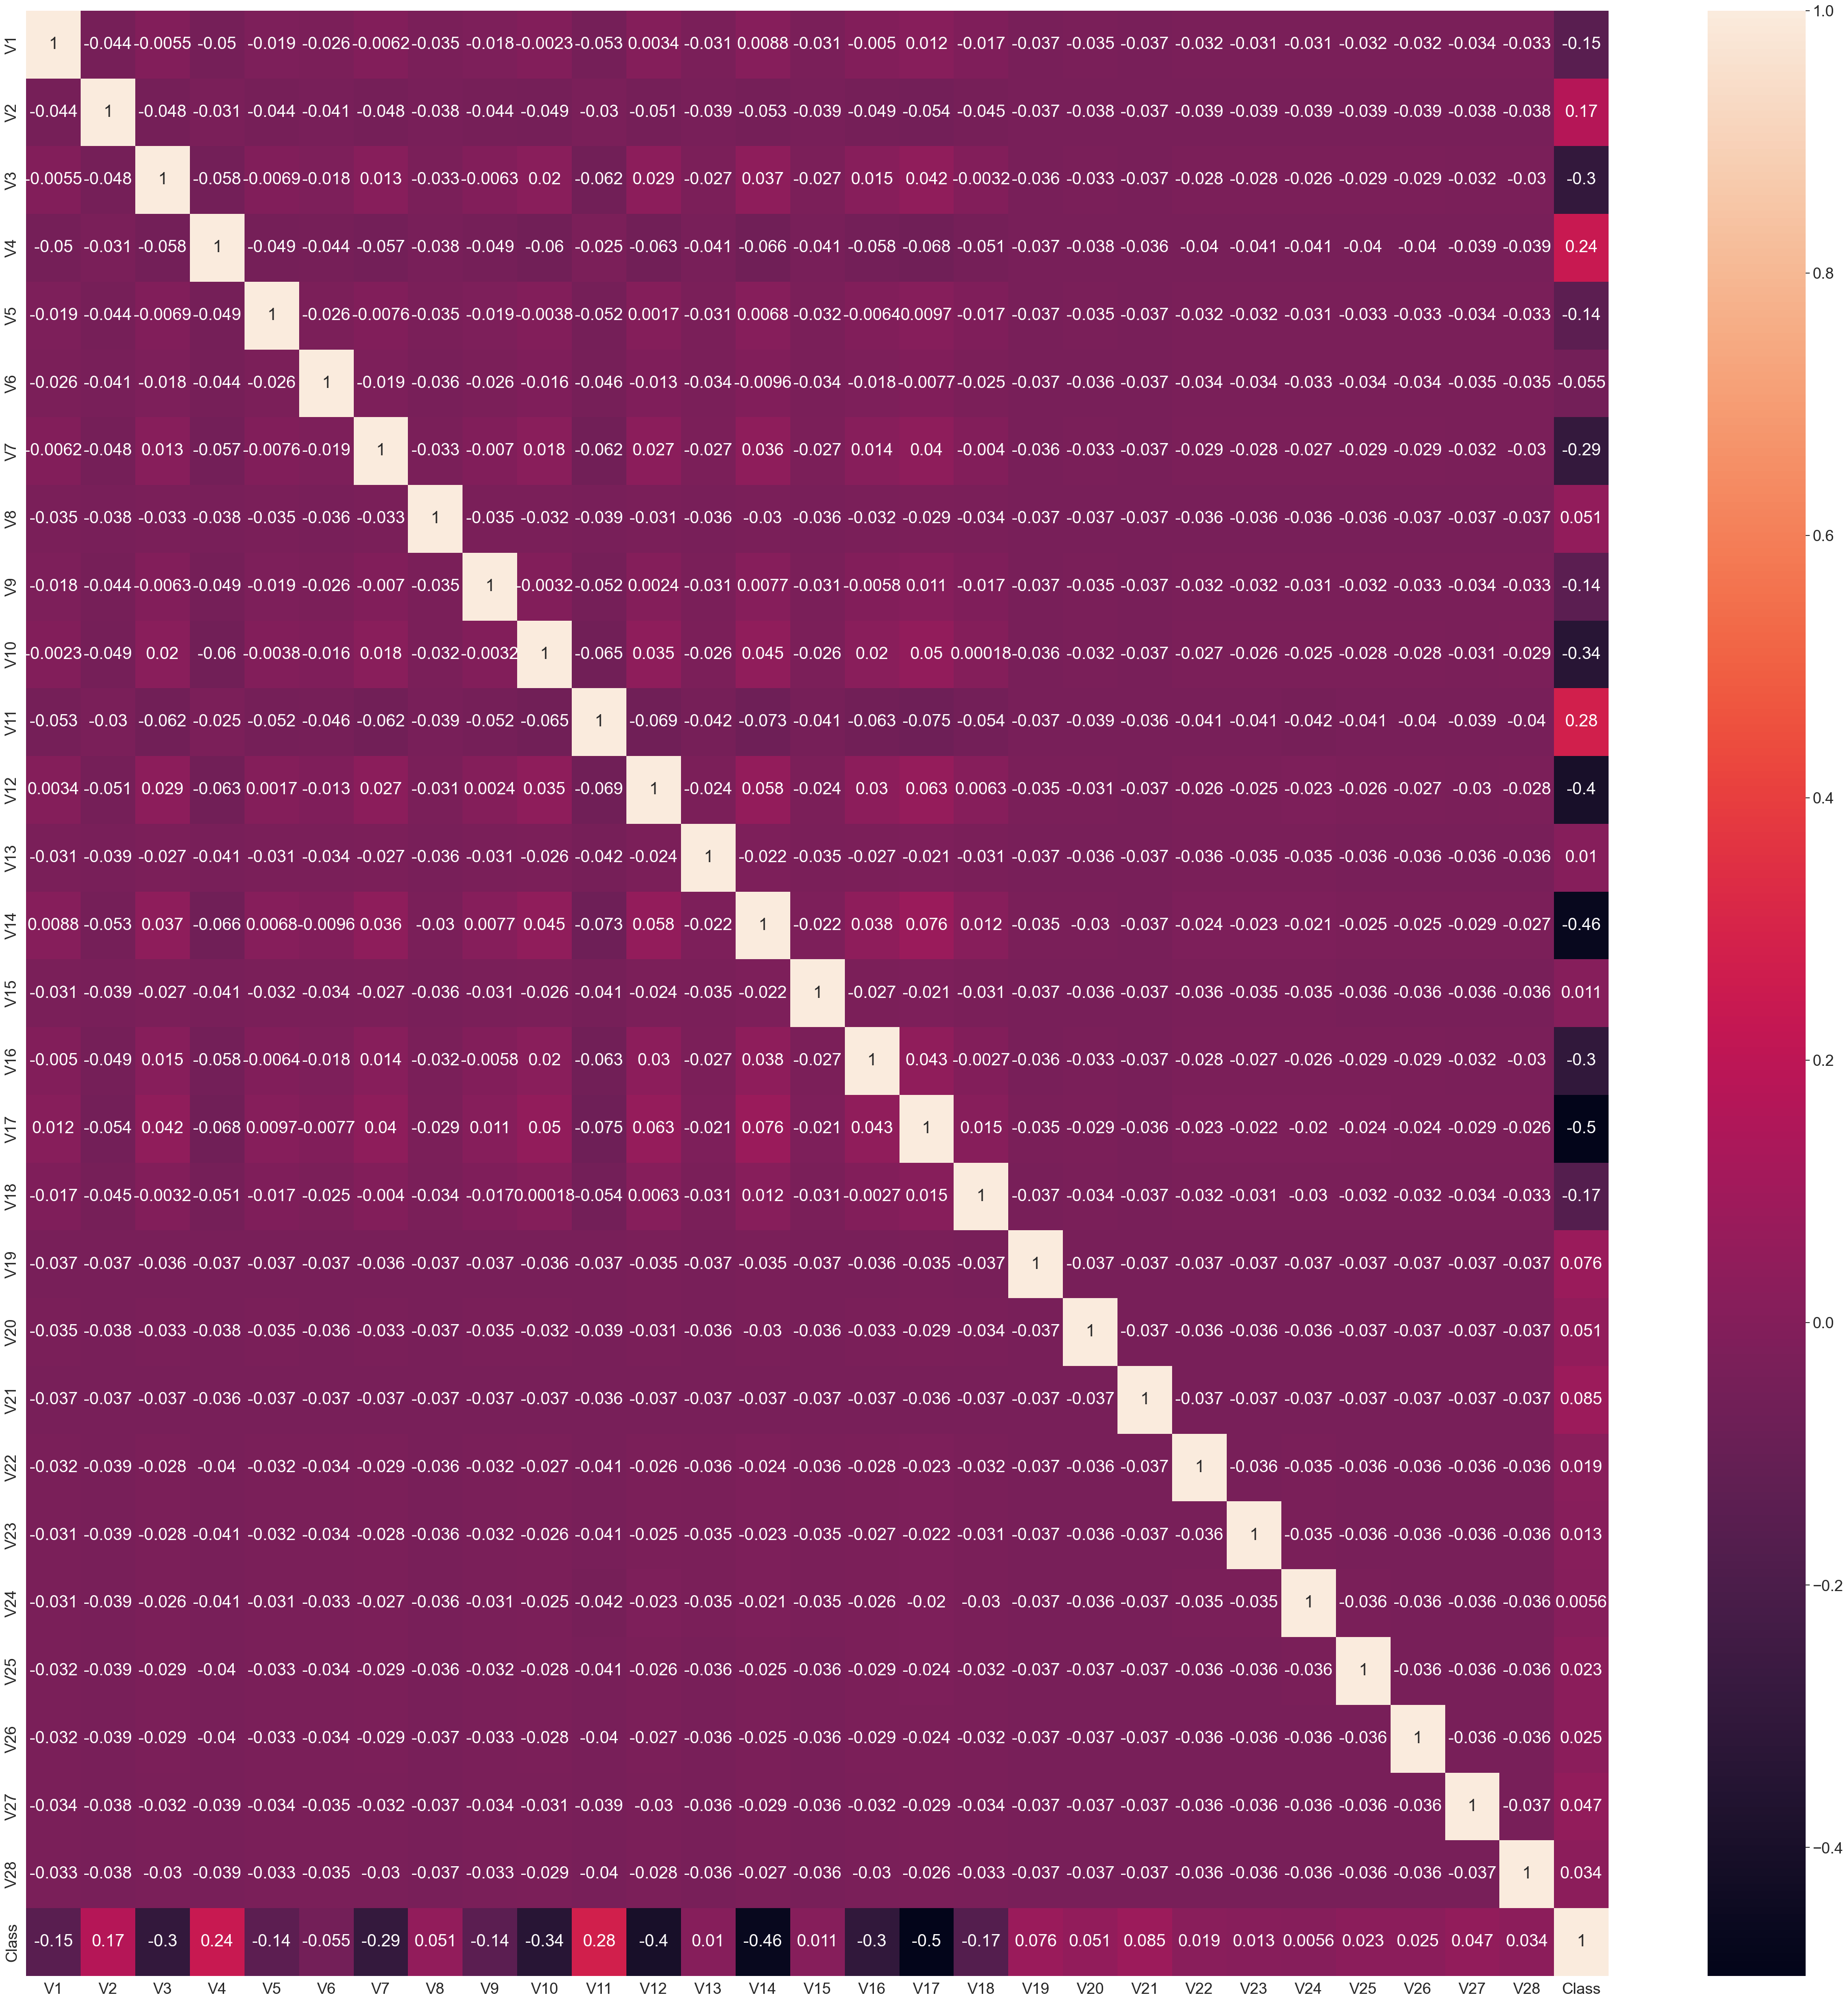

In [11]:
plt.figure(figsize=(50,50))
sns.set(font_scale=2.0) 
sns.heatmap(correlation_df.astype(float).corr(),annot = True)

In [12]:
df = df[['V1','V3','V4','V7','V10','V11','V12','V14','V16','V17','V18','Class']]
#'Class' Column과 상관계수가 0.1 이상인 특성을 선택함

In [13]:
df

,V1,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,1.191857,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,-1.358354,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,-1.158233,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,-9.834783,-2.066656,-4.918215,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0
284803,-0.732789,2.035030,-0.738589,0.024330,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,0
284804,1.919565,-3.249640,-0.557828,-0.296827,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0
284805,-0.240440,0.702510,0.689799,-0.686180,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,0


# Preprocessing

In [14]:
train = df.sort_values('Class')
train.reset_index(inplace=True,drop=True)

In [15]:
x = train.drop('Class',axis=1)
y = train['Class']

In [16]:
train_x = x[:][:200000]
train_y = y[:200000]
x=x[:][200000:]
y=y[:][200000:]
val_x, test_x, val_y, test_y = train_test_split(x, y, test_size=0.5, random_state=SEED,stratify=y)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(train_y.value_counts())
print(val_y.value_counts())
print(test_y.value_counts())


(200000, 11)
(42403, 11)
(42404, 11)
0    200000
Name: Class, dtype: int64
0    42157
1      246
Name: Class, dtype: int64
0    42158
1      246
Name: Class, dtype: int64


In [17]:
val_normal,val_anomaly  = val_y.value_counts()
val_anomaly_ratio = val_anomaly / (val_normal+val_anomaly)

In [18]:
val_anomaly_ratio #전체데이터 중 anomaly ratio
#contamination의 파라미터를 조정하기 위해서 validation anomaly data ratio를 찾아줌

0.0058014763106383985

train : val : test = 8 : 1 : 1로 데이터 분리. 데이터의 비율을 맞춰주기 위해 train_test_split의 stratify 인자에 train_y 설정

In [19]:
scaler = MinMaxScaler() #Scaler를 MinMaxScaler를 사용, 랜덤포레스트는 스케일링을 안하여도 되지만 one class svm과 비교하기 위해 적용
train_x_minmax = scaler.fit_transform(train_x)
val_x_minmax = scaler.transform(val_x)

## Training

In [25]:
best_f1 = 0
best_con = 0
best_n = 0
tmp_f1_list = []
tmp_con_list = []
tmp_n_est_list = []
for n in range(16):
    tmp_f1 = 0
    tmp_con = 0
    for i in range(101):
        n_estimator = 100+10*(n)
        con = val_anomaly_ratio+ 0.0001*(i-50)
        
        #validation anomaly ratio - 2e-3 부터 validation anomaly ratio +1e-3 까지 파라미터 찾기
    
        iso_clf = IsolationForest(n_estimators=n_estimator, contamination = con, random_state=SEED).fit(train_x_minmax)
        #Train
        pred_val = iso_clf.predict(val_x_minmax)
        #Prediction
        pred_val = [1 if i==-1 else 0 for i in pred_val]
        print("N estimator : "+str(n_estimator))
        print("contamination : "+ str(con))
        print(np.unique(pred_val, return_counts=True))
        print(confusion_matrix(val_y,pred_val))
        f1 = f1_score(val_y, pred_val,average='macro')
        print(f1)
        print("------------------------")
        if best_f1 < f1:
            best_n = n_estimator
            best_f1 = f1
            best_con = con
        if tmp_f1 < f1:
            tmp_f1 = f1
            tmp_con = con
    print("n_estimator : "+str(n_estimator)+", best f1 : " + str(tmp_f1)+", contamination : "+str(tmp_con))
    tmp_f1_list.append(tmp_f1)
    tmp_con_list.append(tmp_con)
    tmp_n_est_list.append(100+10*n)
    print("n estimator modify!!!")
    print("n estimator modify!!!")
    print("n estimator modify!!!")
    print("n estimator modify!!!")
#n_estimator, contamination 파라미터를 조정하며 그리드 서치

N estimator : 100
contamination : 0.0008014763106383984
(array([0, 1]), array([42240,   163]))
[[42127    30]
 [  113   133]]
0.8243361875717606
------------------------
N estimator : 100
contamination : 0.0009014763106383987
(array([0, 1]), array([42232,   171]))
[[42124    33]
 [  108   138]]
0.8300998348603346
------------------------
N estimator : 100
contamination : 0.001001476310638398
(array([0, 1]), array([42229,   174]))
[[42123    34]
 [  106   140]]
0.8325038118487269
------------------------
N estimator : 100
contamination : 0.0011014763106383984
(array([0, 1]), array([42225,   178]))
[[42121    36]
 [  104   142]]
0.8340760995705514
------------------------
N estimator : 100
contamination : 0.0012014763106383986
(array([0, 1]), array([42216,   187]))
[[42115    42]
 [  101   145]]
0.8340255517202031
------------------------
N estimator : 100
contamination : 0.001301476310638398
(array([0, 1]), array([42204,   199]))
[[42112    45]
 [   92   154]]
0.8452554291488599
-------

N estimator : 100
contamination : 0.005701476310638398
(array([0, 1]), array([41995,   408]))
[[41948   209]
 [   47   199]]
0.8027602884310407
------------------------
N estimator : 100
contamination : 0.0058014763106383985
(array([0, 1]), array([41992,   411]))
[[41945   212]
 [   47   199]]
0.8013529961431571
------------------------
N estimator : 100
contamination : 0.005901476310638399
(array([0, 1]), array([41990,   413]))
[[41943   214]
 [   47   199]]
0.8004218284596363
------------------------
N estimator : 100
contamination : 0.006001476310638398
(array([0, 1]), array([41988,   415]))
[[41941   216]
 [   47   199]]
0.7994962229758101
------------------------
N estimator : 100
contamination : 0.0061014763106383985
(array([0, 1]), array([41987,   416]))
[[41940   217]
 [   47   199]]
0.7990354903032005
------------------------
N estimator : 100
contamination : 0.006201476310638399
(array([0, 1]), array([41982,   421]))
[[41935   222]
 [   47   199]]
0.7967522793233222
---------

N estimator : 100
contamination : 0.010601476310638399
(array([0, 1]), array([41824,   579]))
[[41781   376]
 [   43   203]]
0.7435659941841102
------------------------
N estimator : 100
contamination : 0.010701476310638398
(array([0, 1]), array([41819,   584]))
[[41776   381]
 [   43   203]]
0.7420537824346831
------------------------
N estimator : 100
contamination : 0.010801476310638398
(array([0, 1]), array([41818,   585]))
[[41775   382]
 [   43   203]]
0.7417534801522858
------------------------
n_estimator : 100, best f1 : 0.8532648165738312, contamination : 0.002201476310638398
n estimator modify!!!
n estimator modify!!!
n estimator modify!!!
n estimator modify!!!
N estimator : 110
contamination : 0.0008014763106383984
(array([0, 1]), array([42250,   153]))
[[42128    29]
 [  122   124]]
0.8098824667792195
------------------------
N estimator : 110
contamination : 0.0009014763106383987
(array([0, 1]), array([42243,   160]))
[[42126    31]
 [  117   129]]
0.8168572128965985
----

N estimator : 110
contamination : 0.005301476310638398
(array([0, 1]), array([42017,   386]))
[[41967   190]
 [   50   196]]
0.8087009639165165
------------------------
N estimator : 110
contamination : 0.005401476310638398
(array([0, 1]), array([42016,   387]))
[[41966   191]
 [   50   196]]
0.8082050754230703
------------------------
N estimator : 110
contamination : 0.005501476310638399
(array([0, 1]), array([42015,   388]))
[[41965   192]
 [   50   196]]
0.8077107323130299
------------------------
N estimator : 110
contamination : 0.005601476310638399
(array([0, 1]), array([42006,   397]))
[[41956   201]
 [   50   196]]
0.8033299967852872
------------------------
N estimator : 110
contamination : 0.005701476310638398
(array([0, 1]), array([42001,   402]))
[[41952   205]
 [   49   197]]
0.8025032793989201
------------------------
N estimator : 110
contamination : 0.0058014763106383985
(array([0, 1]), array([42000,   403]))
[[41951   206]
 [   49   197]]
0.8020288882253293
----------

N estimator : 110
contamination : 0.010201476310638398
(array([0, 1]), array([41846,   557]))
[[41803   354]
 [   43   203]]
0.7504389816831691
------------------------
N estimator : 110
contamination : 0.010301476310638399
(array([0, 1]), array([41844,   559]))
[[41801   356]
 [   43   203]]
0.7497989413169512
------------------------
N estimator : 110
contamination : 0.010401476310638398
(array([0, 1]), array([41842,   561]))
[[41799   358]
 [   43   203]]
0.7491620135384571
------------------------
N estimator : 110
contamination : 0.0105014763106384
(array([0, 1]), array([41836,   567]))
[[41793   364]
 [   43   203]]
0.7472696759756043
------------------------
N estimator : 110
contamination : 0.010601476310638399
(array([0, 1]), array([41834,   569]))
[[41791   366]
 [   43   203]]
0.7466449699219161
------------------------
N estimator : 110
contamination : 0.010701476310638398
(array([0, 1]), array([41830,   573]))
[[41787   370]
 [   43   203]]
0.7454045340146761
-------------

N estimator : 120
contamination : 0.004901476310638399
(array([0, 1]), array([42028,   375]))
[[41978   179]
 [   50   196]]
0.814259868013635
------------------------
N estimator : 120
contamination : 0.005001476310638398
(array([0, 1]), array([42022,   381]))
[[41972   185]
 [   50   196]]
0.8112038459549811
------------------------
N estimator : 120
contamination : 0.0051014763106383984
(array([0, 1]), array([42020,   383]))
[[41970   187]
 [   50   196]]
0.8101979754107729
------------------------
N estimator : 120
contamination : 0.005201476310638399
(array([0, 1]), array([42016,   387]))
[[41966   191]
 [   50   196]]
0.8082050754230703
------------------------
N estimator : 120
contamination : 0.005301476310638398
(array([0, 1]), array([42015,   388]))
[[41966   191]
 [   49   197]]
0.8092998998145752
------------------------
N estimator : 120
contamination : 0.005401476310638398
(array([0, 1]), array([42009,   394]))
[[41960   197]
 [   49   197]]
0.8063511022859586
-----------

N estimator : 120
contamination : 0.009801476310638399
(array([0, 1]), array([41858,   545]))
[[41815   342]
 [   43   203]]
0.7543459106280537
------------------------
N estimator : 120
contamination : 0.0099014763106384
(array([0, 1]), array([41855,   548]))
[[41812   345]
 [   43   203]]
0.7533583123725518
------------------------
N estimator : 120
contamination : 0.0100014763106384
(array([0, 1]), array([41852,   551]))
[[41809   348]
 [   43   203]]
0.752378012674241
------------------------
N estimator : 120
contamination : 0.010101476310638399
(array([0, 1]), array([41849,   554]))
[[41806   351]
 [   43   203]]
0.7514049294098042
------------------------
N estimator : 120
contamination : 0.010201476310638398
(array([0, 1]), array([41847,   556]))
[[41804   353]
 [   43   203]]
0.750760176364954
------------------------
N estimator : 120
contamination : 0.010301476310638399
(array([0, 1]), array([41847,   556]))
[[41804   353]
 [   43   203]]
0.750760176364954
------------------

N estimator : 130
contamination : 0.004501476310638399
(array([0, 1]), array([42039,   364]))
[[41988   169]
 [   51   195]]
0.8183656557805401
------------------------
N estimator : 130
contamination : 0.004601476310638399
(array([0, 1]), array([42037,   366]))
[[41986   171]
 [   51   195]]
0.8173090672475847
------------------------
N estimator : 130
contamination : 0.004701476310638398
(array([0, 1]), array([42035,   368]))
[[41984   173]
 [   51   195]]
0.8162592838828451
------------------------
N estimator : 130
contamination : 0.0048014763106383985
(array([0, 1]), array([42034,   369]))
[[41983   174]
 [   51   195]]
0.8157369233893548
------------------------
N estimator : 130
contamination : 0.004901476310638399
(array([0, 1]), array([42030,   373]))
[[41979   178]
 [   51   195]]
0.8136641651644305
------------------------
N estimator : 130
contamination : 0.005001476310638398
(array([0, 1]), array([42028,   375]))
[[41977   180]
 [   51   195]]
0.8126376834548021
----------

N estimator : 130
contamination : 0.0094014763106384
(array([0, 1]), array([41867,   536]))
[[41823   334]
 [   44   202]]
0.7560626631338799
------------------------
N estimator : 130
contamination : 0.009501476310638399
(array([0, 1]), array([41861,   542]))
[[41818   339]
 [   43   203]]
0.7553408908146707
------------------------
N estimator : 130
contamination : 0.009601476310638398
(array([0, 1]), array([41858,   545]))
[[41815   342]
 [   43   203]]
0.7543459106280537
------------------------
N estimator : 130
contamination : 0.0097014763106384
(array([0, 1]), array([41857,   546]))
[[41814   343]
 [   43   203]]
0.7540158951382081
------------------------
N estimator : 130
contamination : 0.009801476310638399
(array([0, 1]), array([41853,   550]))
[[41810   347]
 [   43   203]]
0.7527039733843601
------------------------
N estimator : 130
contamination : 0.0099014763106384
(array([0, 1]), array([41848,   555]))
[[41805   352]
 [   43   203]]
0.7510821579566818
-----------------

N estimator : 140
contamination : 0.004101476310638398
(array([0, 1]), array([42056,   347]))
[[42005   152]
 [   51   195]]
0.8276311478628562
------------------------
N estimator : 140
contamination : 0.004201476310638399
(array([0, 1]), array([42052,   351]))
[[42001   156]
 [   51   195]]
0.825404081051984
------------------------
N estimator : 140
contamination : 0.004301476310638399
(array([0, 1]), array([42046,   357]))
[[41995   162]
 [   51   195]]
0.822118284035566
------------------------
N estimator : 140
contamination : 0.004401476310638398
(array([0, 1]), array([42045,   358]))
[[41994   163]
 [   51   195]]
0.8215769284553969
------------------------
N estimator : 140
contamination : 0.004501476310638399
(array([0, 1]), array([42039,   364]))
[[41988   169]
 [   51   195]]
0.8183656557805401
------------------------
N estimator : 140
contamination : 0.004601476310638399
(array([0, 1]), array([42036,   367]))
[[41985   172]
 [   51   195]]
0.8167833290825677
-------------

N estimator : 140
contamination : 0.009001476310638398
(array([0, 1]), array([41884,   519]))
[[41841   316]
 [   43   203]]
0.7632236148664755
------------------------
N estimator : 140
contamination : 0.009101476310638398
(array([0, 1]), array([41879,   524]))
[[41836   321]
 [   43   203]]
0.7614706251433369
------------------------
N estimator : 140
contamination : 0.009201476310638399
(array([0, 1]), array([41876,   527]))
[[41833   324]
 [   43   203]]
0.7604295294020589
------------------------
N estimator : 140
contamination : 0.009301476310638398
(array([0, 1]), array([41872,   531]))
[[41829   328]
 [   43   203]]
0.7590536900656026
------------------------
N estimator : 140
contamination : 0.0094014763106384
(array([0, 1]), array([41870,   533]))
[[41827   330]
 [   43   203]]
0.7583709759652564
------------------------
N estimator : 140
contamination : 0.009501476310638399
(array([0, 1]), array([41862,   541]))
[[41819   338]
 [   43   203]]
0.7556742058994249
-------------

N estimator : 150
contamination : 0.0037014763106383982
(array([0, 1]), array([42075,   328]))
[[42018   139]
 [   57   189]]
0.8281048393635232
------------------------
N estimator : 150
contamination : 0.0038014763106383985
(array([0, 1]), array([42071,   332]))
[[42015   142]
 [   56   190]]
0.827544342074971
------------------------
N estimator : 150
contamination : 0.0039014763106383988
(array([0, 1]), array([42066,   337]))
[[42010   147]
 [   56   190]]
0.8246953805902321
------------------------
N estimator : 150
contamination : 0.004001476310638398
(array([0, 1]), array([42062,   341]))
[[42006   151]
 [   56   190]]
0.8224507885895684
------------------------
N estimator : 150
contamination : 0.004101476310638398
(array([0, 1]), array([42061,   342]))
[[42005   152]
 [   56   190]]
0.8218943612972036
------------------------
N estimator : 150
contamination : 0.004201476310638399
(array([0, 1]), array([42055,   348]))
[[42002   155]
 [   53   193]]
0.8236808465279468
---------

N estimator : 150
contamination : 0.008601476310638399
(array([0, 1]), array([41896,   507]))
[[41850   307]
 [   46   200]]
0.7635043841069796
------------------------
N estimator : 150
contamination : 0.008701476310638398
(array([0, 1]), array([41894,   509]))
[[41848   309]
 [   46   200]]
0.7627888491857789
------------------------
N estimator : 150
contamination : 0.0088014763106384
(array([0, 1]), array([41890,   513]))
[[41844   313]
 [   46   200]]
0.7613689015492664
------------------------
N estimator : 150
contamination : 0.008901476310638399
(array([0, 1]), array([41884,   519]))
[[41839   318]
 [   45   201]]
0.7605854378733443
------------------------
N estimator : 150
contamination : 0.009001476310638398
(array([0, 1]), array([41878,   525]))
[[41833   324]
 [   45   201]]
0.7585048753310356
------------------------
N estimator : 150
contamination : 0.009101476310638398
(array([0, 1]), array([41873,   530]))
[[41828   329]
 [   45   201]]
0.7567952228646864
-------------

N estimator : 160
contamination : 0.0033014763106383985
(array([0, 1]), array([42096,   307]))
[[42032   125]
 [   64   182]]
0.8279923022686192
------------------------
N estimator : 160
contamination : 0.0034014763106383983
(array([0, 1]), array([42091,   312]))
[[42029   128]
 [   62   184]]
0.8286214807349798
------------------------
N estimator : 160
contamination : 0.0035014763106383986
(array([0, 1]), array([42089,   314]))
[[42028   129]
 [   61   185]]
0.8292294928796959
------------------------
N estimator : 160
contamination : 0.0036014763106383984
(array([0, 1]), array([42081,   322]))
[[42024   133]
 [   57   189]]
0.8316187218039832
------------------------
N estimator : 160
contamination : 0.0037014763106383982
(array([0, 1]), array([42076,   327]))
[[42020   137]
 [   56   190]]
0.8304425008757289
------------------------
N estimator : 160
contamination : 0.0038014763106383985
(array([0, 1]), array([42071,   332]))
[[42015   142]
 [   56   190]]
0.827544342074971
------

N estimator : 160
contamination : 0.0082014763106384
(array([0, 1]), array([41904,   499]))
[[41858   299]
 [   46   200]]
0.7664042946121981
------------------------
N estimator : 160
contamination : 0.008301476310638399
(array([0, 1]), array([41903,   500]))
[[41857   300]
 [   46   200]]
0.7660384609741924
------------------------
N estimator : 160
contamination : 0.008401476310638398
(array([0, 1]), array([41900,   503]))
[[41854   303]
 [   46   200]]
0.7649467246723181
------------------------
N estimator : 160
contamination : 0.008501476310638398
(array([0, 1]), array([41896,   507]))
[[41850   307]
 [   46   200]]
0.7635043841069796
------------------------
N estimator : 160
contamination : 0.008601476310638399
(array([0, 1]), array([41894,   509]))
[[41849   308]
 [   45   201]]
0.7641252500354365
------------------------
N estimator : 160
contamination : 0.008701476310638398
(array([0, 1]), array([41890,   513]))
[[41845   312]
 [   45   201]]
0.7626983227105518
-------------

N estimator : 170
contamination : 0.0029014763106383983
(array([0, 1]), array([42106,   297]))
[[42042   115]
 [   64   182]]
0.8341128033121065
------------------------
N estimator : 170
contamination : 0.0030014763106383986
(array([0, 1]), array([42102,   301]))
[[42038   119]
 [   64   182]]
0.8316380114044202
------------------------
N estimator : 170
contamination : 0.0031014763106383984
(array([0, 1]), array([42102,   301]))
[[42038   119]
 [   64   182]]
0.8316380114044202
------------------------
N estimator : 170
contamination : 0.0032014763106383982
(array([0, 1]), array([42099,   304]))
[[42036   121]
 [   63   183]]
0.8316353623588717
------------------------
N estimator : 170
contamination : 0.0033014763106383985
(array([0, 1]), array([42091,   312]))
[[42030   127]
 [   61   185]]
0.8304254651482957
------------------------
N estimator : 170
contamination : 0.0034014763106383983
(array([0, 1]), array([42086,   317]))
[[42027   130]
 [   59   187]]
0.8310274457872218
-----

N estimator : 170
contamination : 0.007801476310638399
(array([0, 1]), array([41927,   476]))
[[41881   276]
 [   46   200]]
0.7750935583345555
------------------------
N estimator : 170
contamination : 0.007901476310638398
(array([0, 1]), array([41925,   478]))
[[41879   278]
 [   46   200]]
0.7743164033111061
------------------------
N estimator : 170
contamination : 0.008001476310638399
(array([0, 1]), array([41920,   483]))
[[41874   283]
 [   46   200]]
0.7723918826580893
------------------------
N estimator : 170
contamination : 0.008101476310638399
(array([0, 1]), array([41912,   491]))
[[41866   291]
 [   46   200]]
0.7693661146374029
------------------------
N estimator : 170
contamination : 0.0082014763106384
(array([0, 1]), array([41906,   497]))
[[41860   297]
 [   46   200]]
0.7671388674734416
------------------------
N estimator : 170
contamination : 0.008301476310638399
(array([0, 1]), array([41903,   500]))
[[41857   300]
 [   46   200]]
0.7660384609741924
-------------

N estimator : 180
contamination : 0.0025014763106383986
(array([0, 1]), array([42138,   265]))
[[42067    90]
 [   71   175]]
0.8415107738885047
------------------------
N estimator : 180
contamination : 0.0026014763106383984
(array([0, 1]), array([42126,   277]))
[[42057   100]
 [   69   177]]
0.8374295477117529
------------------------
N estimator : 180
contamination : 0.002701476310638398
(array([0, 1]), array([42118,   285]))
[[42051   106]
 [   67   179]]
0.8360734100148546
------------------------
N estimator : 180
contamination : 0.0028014763106383985
(array([0, 1]), array([42114,   289]))
[[42048   109]
 [   66   180]]
0.8354102812721352
------------------------
N estimator : 180
contamination : 0.0029014763106383983
(array([0, 1]), array([42108,   295]))
[[42044   113]
 [   64   182]]
0.8353637899448674
------------------------
N estimator : 180
contamination : 0.0030014763106383986
(array([0, 1]), array([42104,   299]))
[[42041   116]
 [   63   183]]
0.8347176406554166
------

N estimator : 180
contamination : 0.007401476310638398
(array([0, 1]), array([41936,   467]))
[[41890   267]
 [   46   200]]
0.7786438740292025
------------------------
N estimator : 180
contamination : 0.007501476310638399
(array([0, 1]), array([41931,   472]))
[[41885   272]
 [   46   200]]
0.776660655808519
------------------------
N estimator : 180
contamination : 0.007601476310638399
(array([0, 1]), array([41927,   476]))
[[41881   276]
 [   46   200]]
0.7750935583345555
------------------------
N estimator : 180
contamination : 0.007701476310638398
(array([0, 1]), array([41925,   478]))
[[41879   278]
 [   46   200]]
0.7743164033111061
------------------------
N estimator : 180
contamination : 0.007801476310638399
(array([0, 1]), array([41922,   481]))
[[41876   281]
 [   46   200]]
0.7731585639646921
------------------------
N estimator : 180
contamination : 0.007901476310638398
(array([0, 1]), array([41919,   484]))
[[41873   284]
 [   46   200]]
0.7720100926298255
------------

N estimator : 190
contamination : 0.0021014763106383984
(array([0, 1]), array([42157,   246]))
[[42076    81]
 [   81   165]]
0.8344051591119608
------------------------
N estimator : 190
contamination : 0.002201476310638398
(array([0, 1]), array([42154,   249]))
[[42076    81]
 [   78   168]]
0.8384510019361937
------------------------
N estimator : 190
contamination : 0.0023014763106383985
(array([0, 1]), array([42148,   255]))
[[42070    87]
 [   78   168]]
0.834350751672623
------------------------
N estimator : 190
contamination : 0.0024014763106383983
(array([0, 1]), array([42144,   259]))
[[42069    88]
 [   75   171]]
0.837647087563764
------------------------
N estimator : 190
contamination : 0.0025014763106383986
(array([0, 1]), array([42134,   269]))
[[42062    95]
 [   72   174]]
0.8368734618271676
------------------------
N estimator : 190
contamination : 0.0026014763106383984
(array([0, 1]), array([42124,   279]))
[[42056   101]
 [   68   178]]
0.8380450205971973
--------

N estimator : 190
contamination : 0.007001476310638398
(array([0, 1]), array([41945,   458]))
[[41898   259]
 [   47   199]]
0.7808512350262993
------------------------
N estimator : 190
contamination : 0.0071014763106383985
(array([0, 1]), array([41943,   460]))
[[41896   261]
 [   47   199]]
0.7800385349964463
------------------------
N estimator : 190
contamination : 0.007201476310638399
(array([0, 1]), array([41938,   465]))
[[41891   266]
 [   47   199]]
0.7780264918727222
------------------------
N estimator : 190
contamination : 0.007301476310638398
(array([0, 1]), array([41937,   466]))
[[41890   267]
 [   47   199]]
0.7776274236187808
------------------------
N estimator : 190
contamination : 0.007401476310638398
(array([0, 1]), array([41935,   468]))
[[41888   269]
 [   47   199]]
0.7768325900497667
------------------------
N estimator : 190
contamination : 0.007501476310638399
(array([0, 1]), array([41932,   471]))
[[41886   271]
 [   46   200]]
0.7770551202366398
----------

N estimator : 200
contamination : 0.0017014763106383982
(array([0, 1]), array([42193,   210]))
[[42098    59]
 [   95   151]]
0.8302274878066536
------------------------
N estimator : 200
contamination : 0.0018014763106383985
(array([0, 1]), array([42180,   223]))
[[42088    69]
 [   92   154]]
0.8274037050008504
------------------------
N estimator : 200
contamination : 0.0019014763106383983
(array([0, 1]), array([42175,   228]))
[[42086    71]
 [   89   157]]
0.8302749970930645
------------------------
N estimator : 200
contamination : 0.0020014763106383985
(array([0, 1]), array([42158,   245]))
[[42077    80]
 [   81   165]]
0.8350941268275197
------------------------
N estimator : 200
contamination : 0.0021014763106383984
(array([0, 1]), array([42157,   246]))
[[42077    80]
 [   80   166]]
0.8364495398636649
------------------------
N estimator : 200
contamination : 0.002201476310638398
(array([0, 1]), array([42155,   248]))
[[42076    81]
 [   79   167]]
0.8371078235341798
------

N estimator : 200
contamination : 0.006601476310638399
(array([0, 1]), array([41955,   448]))
[[41908   249]
 [   47   199]]
0.7849839571664842
------------------------
N estimator : 200
contamination : 0.006701476310638398
(array([0, 1]), array([41952,   451]))
[[41905   252]
 [   47   199]]
0.7837318702367715
------------------------
N estimator : 200
contamination : 0.0068014763106383986
(array([0, 1]), array([41950,   453]))
[[41903   254]
 [   47   199]]
0.7829030304115817
------------------------
N estimator : 200
contamination : 0.006901476310638399
(array([0, 1]), array([41947,   456]))
[[41900   257]
 [   47   199]]
0.7816684972587189
------------------------
N estimator : 200
contamination : 0.007001476310638398
(array([0, 1]), array([41943,   460]))
[[41896   261]
 [   47   199]]
0.7800385349964463
------------------------
N estimator : 200
contamination : 0.0071014763106383985
(array([0, 1]), array([41942,   461]))
[[41895   262]
 [   47   199]]
0.7796338837067709
---------

N estimator : 210
contamination : 0.001301476310638398
(array([0, 1]), array([42220,   183]))
[[42113    44]
 [  107   139]]
0.8231145304044316
------------------------
N estimator : 210
contamination : 0.0014014763106383983
(array([0, 1]), array([42216,   187]))
[[42111    46]
 [  105   141]]
0.8247402679003542
------------------------
N estimator : 210
contamination : 0.0015014763106383985
(array([0, 1]), array([42208,   195]))
[[42107    50]
 [  101   145]]
0.8279032650615314
------------------------
N estimator : 210
contamination : 0.001601476310638398
(array([0, 1]), array([42204,   199]))
[[42107    50]
 [   97   149]]
0.8339602049991417
------------------------
N estimator : 210
contamination : 0.0017014763106383982
(array([0, 1]), array([42192,   211]))
[[42098    59]
 [   94   152]]
0.8316969925904131
------------------------
N estimator : 210
contamination : 0.0018014763106383985
(array([0, 1]), array([42176,   227]))
[[42089    68]
 [   87   159]]
0.8352332439088181
-------

N estimator : 210
contamination : 0.006201476310638399
(array([0, 1]), array([41975,   428]))
[[41927   230]
 [   48   198]]
0.7921163803496019
------------------------
N estimator : 210
contamination : 0.006301476310638399
(array([0, 1]), array([41971,   432]))
[[41923   234]
 [   48   198]]
0.7903593807329412
------------------------
N estimator : 210
contamination : 0.006401476310638398
(array([0, 1]), array([41967,   436]))
[[41920   237]
 [   47   199]]
0.7901008719010102
------------------------
N estimator : 210
contamination : 0.006501476310638399
(array([0, 1]), array([41963,   440]))
[[41916   241]
 [   47   199]]
0.7883756233286059
------------------------
N estimator : 210
contamination : 0.006601476310638399
(array([0, 1]), array([41959,   444]))
[[41912   245]
 [   47   199]]
0.7866700987800836
------------------------
N estimator : 210
contamination : 0.006701476310638398
(array([0, 1]), array([41956,   447]))
[[41909   248]
 [   47   199]]
0.7854036937769536
-----------

N estimator : 220
contamination : 0.0009014763106383987
(array([0, 1]), array([42251,   152]))
[[42126    31]
 [  125   121]]
0.8030960174772068
------------------------
N estimator : 220
contamination : 0.001001476310638398
(array([0, 1]), array([42241,   162]))
[[42123    34]
 [  118   128]]
0.8128249949236785
------------------------
N estimator : 220
contamination : 0.0011014763106383984
(array([0, 1]), array([42233,   170]))
[[42120    37]
 [  113   133]]
0.8188228075692525
------------------------
N estimator : 220
contamination : 0.0012014763106383986
(array([0, 1]), array([42226,   177]))
[[42116    41]
 [  110   136]]
0.820618272382909
------------------------
N estimator : 220
contamination : 0.001301476310638398
(array([0, 1]), array([42223,   180]))
[[42114    43]
 [  109   137]]
0.8206955567647808
------------------------
N estimator : 220
contamination : 0.0014014763106383983
(array([0, 1]), array([42214,   189]))
[[42109    48]
 [  105   141]]
0.8232312213830622
--------

N estimator : 220
contamination : 0.0058014763106383985
(array([0, 1]), array([41994,   409]))
[[41944   213]
 [   50   196]]
0.7976739741110604
------------------------
N estimator : 220
contamination : 0.005901476310638399
(array([0, 1]), array([41988,   415]))
[[41938   219]
 [   50   196]]
0.7949219923212659
------------------------
N estimator : 220
contamination : 0.006001476310638398
(array([0, 1]), array([41987,   416]))
[[41937   220]
 [   50   196]]
0.7944681150828188
------------------------
N estimator : 220
contamination : 0.0061014763106383985
(array([0, 1]), array([41979,   424]))
[[41931   226]
 [   48   198]]
0.7938940719999886
------------------------
N estimator : 220
contamination : 0.006201476310638399
(array([0, 1]), array([41975,   428]))
[[41927   230]
 [   48   198]]
0.7921163803496019
------------------------
N estimator : 220
contamination : 0.006301476310638399
(array([0, 1]), array([41971,   432]))
[[41923   234]
 [   48   198]]
0.7903593807329412
---------

N estimator : 220
contamination : 0.010701476310638398
(array([0, 1]), array([41826,   577]))
[[41784   373]
 [   42   204]]
0.7454028949242447
------------------------
N estimator : 220
contamination : 0.010801476310638398
(array([0, 1]), array([41825,   578]))
[[41783   374]
 [   42   204]]
0.7450960943318182
------------------------
n_estimator : 220, best f1 : 0.842062287727585, contamination : 0.0025014763106383986
n estimator modify!!!
n estimator modify!!!
n estimator modify!!!
n estimator modify!!!
N estimator : 230
contamination : 0.0008014763106383984
(array([0, 1]), array([42262,   141]))
[[42130    27]
 [  132   114]]
0.7936319122839737
------------------------
N estimator : 230
contamination : 0.0009014763106383987
(array([0, 1]), array([42247,   156]))
[[42125    32]
 [  122   124]]
0.807545432403878
------------------------
N estimator : 230
contamination : 0.001001476310638398
(array([0, 1]), array([42240,   163]))
[[42123    34]
 [  117   129]]
0.814508841421929
------

N estimator : 230
contamination : 0.005401476310638398
(array([0, 1]), array([42009,   394]))
[[41958   199]
 [   51   195]]
0.8032023397215027
------------------------
N estimator : 230
contamination : 0.005501476310638399
(array([0, 1]), array([42008,   395]))
[[41957   200]
 [   51   195]]
0.8027210498507269
------------------------
N estimator : 230
contamination : 0.005601476310638399
(array([0, 1]), array([42000,   403]))
[[41949   208]
 [   51   195]]
0.7989234590210209
------------------------
N estimator : 230
contamination : 0.005701476310638398
(array([0, 1]), array([41994,   409]))
[[41944   213]
 [   50   196]]
0.7976739741110604
------------------------
N estimator : 230
contamination : 0.0058014763106383985
(array([0, 1]), array([41991,   412]))
[[41941   216]
 [   50   196]]
0.7962917918682282
------------------------
N estimator : 230
contamination : 0.005901476310638399
(array([0, 1]), array([41988,   415]))
[[41939   218]
 [   49   197]]
0.7964467358727807
----------

N estimator : 230
contamination : 0.010301476310638399
(array([0, 1]), array([41839,   564]))
[[41797   360]
 [   42   204]]
0.7494588807579903
------------------------
N estimator : 230
contamination : 0.010401476310638398
(array([0, 1]), array([41831,   572]))
[[41789   368]
 [   42   204]]
0.74694792817649
------------------------
N estimator : 230
contamination : 0.0105014763106384
(array([0, 1]), array([41828,   575]))
[[41786   371]
 [   42   204]]
0.7460186941044298
------------------------
N estimator : 230
contamination : 0.010601476310638399
(array([0, 1]), array([41827,   576]))
[[41785   372]
 [   42   204]]
0.7457104272902868
------------------------
N estimator : 230
contamination : 0.010701476310638398
(array([0, 1]), array([41826,   577]))
[[41784   373]
 [   42   204]]
0.7454028949242447
------------------------
N estimator : 230
contamination : 0.010801476310638398
(array([0, 1]), array([41822,   581]))
[[41781   376]
 [   41   205]]
0.7454011542270609
---------------

N estimator : 240
contamination : 0.005001476310638398
(array([0, 1]), array([42018,   385]))
[[41967   190]
 [   51   195]]
0.8076017390755901
------------------------
N estimator : 240
contamination : 0.0051014763106383984
(array([0, 1]), array([42017,   386]))
[[41966   191]
 [   51   195]]
0.8071068052824875
------------------------
N estimator : 240
contamination : 0.005201476310638399
(array([0, 1]), array([42013,   390]))
[[41962   195]
 [   51   195]]
0.8051424453206786
------------------------
N estimator : 240
contamination : 0.005301476310638398
(array([0, 1]), array([42011,   392]))
[[41960   197]
 [   51   195]]
0.8041693892406261
------------------------
N estimator : 240
contamination : 0.005401476310638398
(array([0, 1]), array([42010,   393]))
[[41959   198]
 [   51   195]]
0.8036851171862602
------------------------
N estimator : 240
contamination : 0.005501476310638399
(array([0, 1]), array([42008,   395]))
[[41957   200]
 [   51   195]]
0.8027210498507269
----------

N estimator : 240
contamination : 0.0099014763106384
(array([0, 1]), array([41860,   543]))
[[41817   340]
 [   43   203]]
0.7550084053391752
------------------------
N estimator : 240
contamination : 0.0100014763106384
(array([0, 1]), array([41855,   548]))
[[41812   345]
 [   43   203]]
0.7533583123725518
------------------------
N estimator : 240
contamination : 0.010101476310638399
(array([0, 1]), array([41852,   551]))
[[41809   348]
 [   43   203]]
0.752378012674241
------------------------
N estimator : 240
contamination : 0.010201476310638398
(array([0, 1]), array([41845,   558]))
[[41802   355]
 [   43   203]]
0.7501185709745599
------------------------
N estimator : 240
contamination : 0.010301476310638399
(array([0, 1]), array([41839,   564]))
[[41796   361]
 [   43   203]]
0.7482124075279305
------------------------
N estimator : 240
contamination : 0.010401476310638398
(array([0, 1]), array([41835,   568]))
[[41792   365]
 [   43   203]]
0.746956946642631
-----------------

N estimator : 250
contamination : 0.004601476310638399
(array([0, 1]), array([42039,   364]))
[[41987   170]
 [   52   194]]
0.8167144344694541
------------------------
N estimator : 250
contamination : 0.004701476310638398
(array([0, 1]), array([42032,   371]))
[[41981   176]
 [   51   195]]
0.8146972237525382
------------------------
N estimator : 250
contamination : 0.0048014763106383985
(array([0, 1]), array([42028,   375]))
[[41977   180]
 [   51   195]]
0.8126376834548021
------------------------
N estimator : 250
contamination : 0.004901476310638399
(array([0, 1]), array([42024,   379]))
[[41973   184]
 [   51   195]]
0.8106041980969578
------------------------
N estimator : 250
contamination : 0.005001476310638398
(array([0, 1]), array([42022,   381]))
[[41971   186]
 [   51   195]]
0.8095970701758743
------------------------
N estimator : 250
contamination : 0.0051014763106383984
(array([0, 1]), array([42020,   383]))
[[41969   188]
 [   51   195]]
0.8085962705619185
---------

N estimator : 250
contamination : 0.009501476310638399
(array([0, 1]), array([41868,   535]))
[[41825   332]
 [   43   203]]
0.7576916966895637
------------------------
N estimator : 250
contamination : 0.009601476310638398
(array([0, 1]), array([41866,   537]))
[[41823   334]
 [   43   203]]
0.7570158259136277
------------------------
N estimator : 250
contamination : 0.0097014763106384
(array([0, 1]), array([41863,   540]))
[[41820   337]
 [   43   203]]
0.7560083537604338
------------------------
N estimator : 250
contamination : 0.009801476310638399
(array([0, 1]), array([41861,   542]))
[[41818   339]
 [   43   203]]
0.7553408908146707
------------------------
N estimator : 250
contamination : 0.0099014763106384
(array([0, 1]), array([41858,   545]))
[[41815   342]
 [   43   203]]
0.7543459106280537
------------------------
N estimator : 250
contamination : 0.0100014763106384
(array([0, 1]), array([41856,   547]))
[[41813   344]
 [   43   203]]
0.7536866967489824
-----------------

In [26]:
print("best_n : "+str(best_n))
print("best contamination : " + str(best_con))
print("best val f1 : " + str(best_f1))=

best_n : 120
best contamination : 0.0023014763106383985
best val f1 : 0.8557196531770054


In [35]:
tmp_con

0.0024014763106383983

In [37]:
for i in range(len(tmp_f1_list)):
    print("N : "+ str(tmp_n_est_list[i]))
    print("con : " + str(tmp_con_list[i]))
    print("f1 :  "+str(tmp_f1_list[i]))

N : 100
con : 0.002201476310638398
f1 :  0.8532648165738312
N : 110
con : 0.002201476310638398
f1 :  0.8492169494448336
N : 120
con : 0.0023014763106383985
f1 :  0.8557196531770054
N : 130
con : 0.0021014763106383984
f1 :  0.854259970509386
N : 140
con : 0.0021014763106383984
f1 :  0.8549920905411662
N : 150
con : 0.0021014763106383984
f1 :  0.8429320690229616
N : 160
con : 0.0021014763106383984
f1 :  0.835071671328357
N : 170
con : 0.0017014763106383982
f1 :  0.8382530962010518
N : 180
con : 0.0025014763106383986
f1 :  0.8415107738885047
N : 190
con : 0.002201476310638398
f1 :  0.8384510019361937
N : 200
con : 0.0025014763106383986
f1 :  0.8406718499306063
N : 210
con : 0.0024014763106383983
f1 :  0.8455314040571852
N : 220
con : 0.0025014763106383986
f1 :  0.842062287727585
N : 230
con : 0.0025014763106383986
f1 :  0.8401124394279256
N : 240
con : 0.0020014763106383985
f1 :  0.8410029200775957
N : 250
con : 0.0024014763106383983
f1 :  0.8395903042132309


ValueError: 'F1-score' is not a valid format string (unrecognized character 'F')

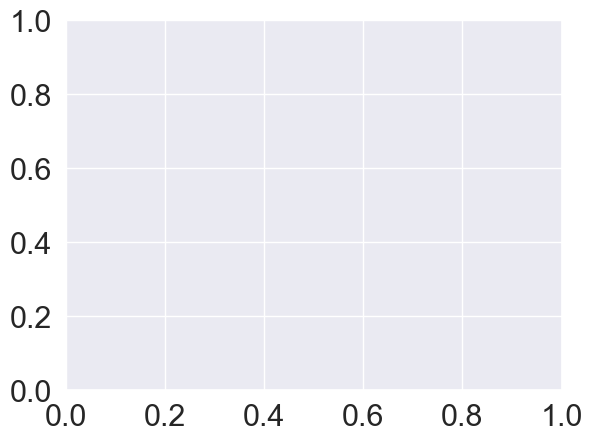

In [40]:
plt.plot(tmp_n_est_list, tmp_f1_list, "F1-score")


In [27]:
test_x_minmax = scaler.transform(test_x)

In [28]:
iso_clf_best = IsolationForest(n_estimators=best_n, contamination = best_con, random_state=SEED).fit(train_x_minmax)
#Best model(Use MinMaxScaler)

In [29]:
pred_test = iso_clf_best.predict(test_x_minmax)
pred_test = [1 if i==-1 else 0 for i in pred_test]
print(np.unique(pred_test, return_counts=True))
print(confusion_matrix(test_y,pred_test))
print(f1_score(test_y, pred_test,average='macro'))
print(classification_report(test_y, pred_test))
#Best model로 결과 뽑음

(array([0, 1]), array([42163,   241]))
[[42093    65]
 [   70   176]]
0.8605957915735475
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42158
           1       0.73      0.72      0.72       246

    accuracy                           1.00     42404
   macro avg       0.86      0.86      0.86     42404
weighted avg       1.00      1.00      1.00     42404



In [ ]:
scaler = StandardScaler() #Scaler를 Standard scaler로 사용, 랜덤포레스트는 스케일링을 안하여도 되지만 one class svm과 비교하기 위해 적용
train_x_normal = scaler.fit_transform(train_x)
val_x_normal = scaler.transform(val_x)

In [218]:
best_f1 = 0
best_con = 0
best_n = 0
for n in range(16):
    for i in range(21):
        n_estimator = 100+10*(n+1)
        con = val_anomaly_ratio+ 0.0001*(i-10) 
        #validation anomaly ratio - 1e-3 부터 validation anomaly ratio +1e-3 까지 파라미터 찾기

        iso_clf = IsolationForest(n_estimators=n_estimator, contamination = con, random_state=SEED).fit(train_x_normal)
        #Train
        pred_val = iso_clf.predict(val_x_normal)
        #Prediction
        pred_val = [1 if i==-1 else 0 for i in pred_val]
        print("N estimator : "+str(n_estimator))
        print("contamination : "+ str(con))
        print(np.unique(pred_val, return_counts=True))
        print(confusion_matrix(val_y,pred_val))
        f1 = f1_score(val_y, pred_val,average='macro')
        print(f1)
        print("------------------------")
        if best_f1 < f1:
            best_f1 = f1
            best_con = con
            best_n = n_estimator
#nu 하이퍼 파리미터를 0.0001 ~ 0.01까지 조정하며 그리드 서치

N estimator : 110
contamination : 0.0048014763106383985
(array([0, 1]), array([42028,   375]))
[[41977   180]
 [   51   195]]
0.8126376834548021
------------------------
N estimator : 110
contamination : 0.004901476310638399
(array([0, 1]), array([42027,   376]))
[[41976   181]
 [   51   195]]
0.8121268891019
------------------------
N estimator : 110
contamination : 0.005001476310638398
(array([0, 1]), array([42024,   379]))
[[41973   184]
 [   51   195]]
0.8106041980969578
------------------------
N estimator : 110
contamination : 0.0051014763106383984
(array([0, 1]), array([42020,   383]))
[[41969   188]
 [   51   195]]
0.8085962705619185
------------------------
N estimator : 110
contamination : 0.005201476310638399
(array([0, 1]), array([42018,   385]))
[[41968   189]
 [   50   196]]
0.8091984051413528
------------------------
N estimator : 110
contamination : 0.005301476310638398
(array([0, 1]), array([42017,   386]))
[[41967   190]
 [   50   196]]
0.8087009639165165
------------

N estimator : 130
contamination : 0.005501476310638399
(array([0, 1]), array([42007,   396]))
[[41957   200]
 [   50   196]]
0.8038107545852106
------------------------
N estimator : 130
contamination : 0.005601476310638399
(array([0, 1]), array([42005,   398]))
[[41955   202]
 [   50   196]]
0.8028507133757566
------------------------
N estimator : 130
contamination : 0.005701476310638398
(array([0, 1]), array([42000,   403]))
[[41950   207]
 [   50   196]]
0.8004761736231751
------------------------
N estimator : 130
contamination : 0.0058014763106383985
(array([0, 1]), array([41995,   408]))
[[41945   212]
 [   50   196]]
0.7981374826911432
------------------------
N estimator : 130
contamination : 0.005901476310638399
(array([0, 1]), array([41993,   410]))
[[41944   213]
 [   49   197]]
0.7987481341390954
------------------------
N estimator : 130
contamination : 0.006001476310638398
(array([0, 1]), array([41992,   411]))
[[41943   214]
 [   49   197]]
0.7982850887476848
----------

N estimator : 150
contamination : 0.006201476310638399
(array([0, 1]), array([41986,   417]))
[[41935   222]
 [   51   195]]
0.7924954087264606
------------------------
N estimator : 150
contamination : 0.006301476310638399
(array([0, 1]), array([41981,   422]))
[[41931   226]
 [   50   196]]
0.791773011062664
------------------------
N estimator : 150
contamination : 0.006401476310638398
(array([0, 1]), array([41976,   427]))
[[41926   231]
 [   50   196]]
0.7895633088832019
------------------------
N estimator : 150
contamination : 0.006501476310638399
(array([0, 1]), array([41972,   431]))
[[41923   234]
 [   49   197]]
0.7893077194369138
------------------------
N estimator : 150
contamination : 0.006601476310638399
(array([0, 1]), array([41965,   438]))
[[41917   240]
 [   48   198]]
0.7877618846812713
------------------------
N estimator : 150
contamination : 0.006701476310638398
(array([0, 1]), array([41963,   440]))
[[41916   241]
 [   47   199]]
0.7883756233286059
------------

N estimator : 180
contamination : 0.0048014763106383985
(array([0, 1]), array([42032,   371]))
[[41981   176]
 [   51   195]]
0.8146972237525382
------------------------
N estimator : 180
contamination : 0.004901476310638399
(array([0, 1]), array([42030,   373]))
[[41979   178]
 [   51   195]]
0.8136641651644305
------------------------
N estimator : 180
contamination : 0.005001476310638398
(array([0, 1]), array([42024,   379]))
[[41973   184]
 [   51   195]]
0.8106041980969578
------------------------
N estimator : 180
contamination : 0.0051014763106383984
(array([0, 1]), array([42021,   382]))
[[41970   187]
 [   51   195]]
0.8090958831096919
------------------------
N estimator : 180
contamination : 0.005201476310638399
(array([0, 1]), array([42021,   382]))
[[41970   187]
 [   51   195]]
0.8090958831096919
------------------------
N estimator : 180
contamination : 0.005301476310638398
(array([0, 1]), array([42016,   387]))
[[41965   192]
 [   51   195]]
0.8066134162979506
---------

N estimator : 200
contamination : 0.005501476310638399
(array([0, 1]), array([42008,   395]))
[[41957   200]
 [   51   195]]
0.8027210498507269
------------------------
N estimator : 200
contamination : 0.005601476310638399
(array([0, 1]), array([42001,   402]))
[[41950   207]
 [   51   195]]
0.7993930948225252
------------------------
N estimator : 200
contamination : 0.005701476310638398
(array([0, 1]), array([41999,   404]))
[[41948   209]
 [   51   195]]
0.7984552497742288
------------------------
N estimator : 200
contamination : 0.0058014763106383985
(array([0, 1]), array([41993,   410]))
[[41942   215]
 [   51   195]]
0.7956755865687
------------------------
N estimator : 200
contamination : 0.005901476310638399
(array([0, 1]), array([41988,   415]))
[[41938   219]
 [   50   196]]
0.7949219923212659
------------------------
N estimator : 200
contamination : 0.006001476310638398
(array([0, 1]), array([41983,   420]))
[[41934   223]
 [   49   197]]
0.7941794420995751
-------------

N estimator : 220
contamination : 0.006201476310638399
(array([0, 1]), array([41975,   428]))
[[41927   230]
 [   48   198]]
0.7921163803496019
------------------------
N estimator : 220
contamination : 0.006301476310638399
(array([0, 1]), array([41971,   432]))
[[41923   234]
 [   48   198]]
0.7903593807329412
------------------------
N estimator : 220
contamination : 0.006401476310638398
(array([0, 1]), array([41966,   437]))
[[41918   239]
 [   48   198]]
0.7881916754781906
------------------------
N estimator : 220
contamination : 0.006501476310638399
(array([0, 1]), array([41962,   441]))
[[41914   243]
 [   48   198]]
0.7864799145274077
------------------------
N estimator : 220
contamination : 0.006601476310638399
(array([0, 1]), array([41956,   447]))
[[41909   248]
 [   47   199]]
0.7854036937769536
------------------------
N estimator : 220
contamination : 0.006701476310638398
(array([0, 1]), array([41954,   449]))
[[41907   250]
 [   47   199]]
0.7845654111229687
-----------

N estimator : 250
contamination : 0.0048014763106383985
(array([0, 1]), array([42028,   375]))
[[41977   180]
 [   51   195]]
0.8126376834548021
------------------------
N estimator : 250
contamination : 0.004901476310638399
(array([0, 1]), array([42024,   379]))
[[41973   184]
 [   51   195]]
0.8106041980969578
------------------------
N estimator : 250
contamination : 0.005001476310638398
(array([0, 1]), array([42022,   381]))
[[41971   186]
 [   51   195]]
0.8095970701758743
------------------------
N estimator : 250
contamination : 0.0051014763106383984
(array([0, 1]), array([42020,   383]))
[[41969   188]
 [   51   195]]
0.8085962705619185
------------------------
N estimator : 250
contamination : 0.005201476310638399
(array([0, 1]), array([42017,   386]))
[[41966   191]
 [   51   195]]
0.8071068052824875
------------------------
N estimator : 250
contamination : 0.005301476310638398
(array([0, 1]), array([42013,   390]))
[[41962   195]
 [   51   195]]
0.8051424453206786
---------

In [219]:
print("best_n : "+str(best_n))
print("best contamination : " + str(best_con))
print("best val f1 : " + str(best_f1))

best_n : 170
best contamination : 0.0048014763106383985
best val f1 : 0.8173090672475847


In [ ]:
ㄹ

In [220]:
test_x_normal = scaler.transform(test_x)

In [221]:
iso_clf_best = IsolationForest(n_estimators=best_n, contamination = best_con, random_state=SEED).fit(train_x_normal)
#best model(Use Standard Scaler)

In [222]:
pred_test = iso_clf_best.predict(test_x_normal)
pred_test = [1 if i==-1 else 0 for i in pred_test]
print(np.unique(pred_test, return_counts=True))
print(confusion_matrix(test_y,pred_test))
print(f1_score(test_y, pred_test,average='macro'))
print(classification_report(test_y, pred_test))
#Best model로 결과 뽑음

(array([0, 1]), array([42029,   375]))
[[41981   177]
 [   48   198]]
0.8175042688783063
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42158
           1       0.53      0.80      0.64       246

    accuracy                           0.99     42404
   macro avg       0.76      0.90      0.82     42404
weighted avg       1.00      0.99      1.00     42404

